# Introduzione 

In questa lezione sviluppiamo un algoritmo di machine learning per l'analisi di immmagini. In particolare ci concentriamo sul riconoscimento di cifre scritte a mano e per farlo usiamo due divere reti neurali: una Deep Neural Network (DNN) ed una Convolutional Neural Network (CNN). La principale differenza fra queste due reti è il modo in cui elaborano i dati. 
* Una rete DNN riduce l'immagine ad un vettore di pixel e l'informazione contenuta viene processata ed analizzata pixel per pixel dalla rete. Questo tipo di network evidentemente non conserva le proprietà di invarianza traslazionale presente nell'immagine e per questo motivo non è ottimale per svolgere questo tipo di task.

* Una rete CNN, invece, prende in input l'immagine sotto forma di matrice di pixel ed analizza l'informazione contenuta attraverso una serie di layer convoluti. Questa procedura conserva invece l'invarianza traslazionale presente nell'immagine ed è quindi più adatta per il riconoscimento di immagini.

In [1]:
import matplotlib as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math
import string
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stat
import pandas as pd
import subprocess as sb
from os import system
import os
import shutil
# compose the NN model
import tensorflow as tf
from tensorflow import keras
from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from keras.datasets import mnist

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

In [2]:
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

## 1. Algoritmo sequenziale con diverse funzioni di ottimizzazione

Quello che ora andiamo a fare è creare una rete neurale di tipo sequenziale in cui facciamo uso di tre diversi tipi di funzione di ottimizzazione. In particolare scegliamo di usare la funzione **RMSprop**, **Adagrad** e **Adam**. Cerchiamo ora di comprendere il comportamento di questi due algortimi

* L'algoritmo **Adagrad** si fonda sull'idea di effettuare un'upgrade dei parametri con uno step che non dipenda solo dall'intensità del gradiente in quel punto per quella data direzione. Infatti, quando lo spazio dei parametri presenta una forma molto corrugata caratterizzata da selle e plateu, risulta difficile convergare al minimo globale muovendosi con step proporzionali all'intensità del gradiente, come nell'algoritmo gds. Quello che esegue il Adagrad è un apdate dei parametri con uno step pari al gradiente nel punto fratto la radice quadrata dei valor medi dei gradienti dei batchs dei passi effettuati in quella direzione fino al passo considerato. Quello che succede è che man mano che l'algoritmo processa i dati, abbiamo una fase inziale in cui gli step sono ampi, poichè il valor medio è piccolo, ed una fase finale in cui l'algortimo rallenta in prossimità del minimo. 

* L'algoritmo **RMSprop** è simile all'Adagrad ma piuttosto che considerare la media di tutti i batch effettuati fino a quel momento ne considera solo alcuni. In particolare, usa uno step pari al gradiente nel punto fratto la radice quadrata della *media mobile* dei valori medi dei gradienti dei batchs dei passi effettuati in quella direzione.  

* L'algoritmo **Adam** invece integra l'algoritmo RMSprop con il calcolo anche del secondo momento della distribuzione dei gradienti. In questo modo la direzione degli step viene decisa non soltanto sulla base delle informazioni locali ma anche della conformazioni spaziale nell'interno del punto.

Nel video qui sotto osserviamo diversi algortimo a confronto. La cosa più evidente è come il gds rallenti notevolemte in prossimità del punto di sella dove il gradiente è molto piccolo. 

![Alt Text](https://i.imgur.com/2dKCQHh.gif)

Vediamo ora all'implementazione dei diversi algoritmi.

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [4]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [5]:
def compile_model(optimazer_):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimazer_,
                  metrics=['acc'])
    return model

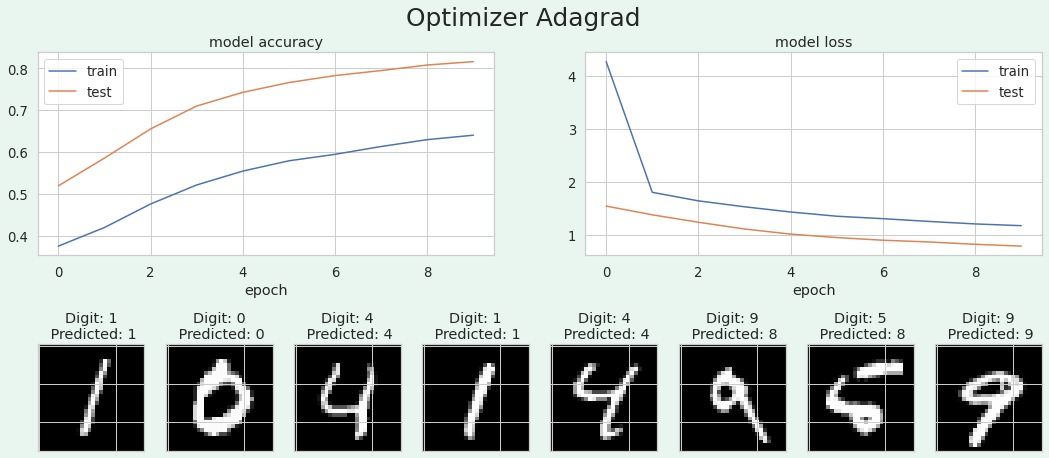

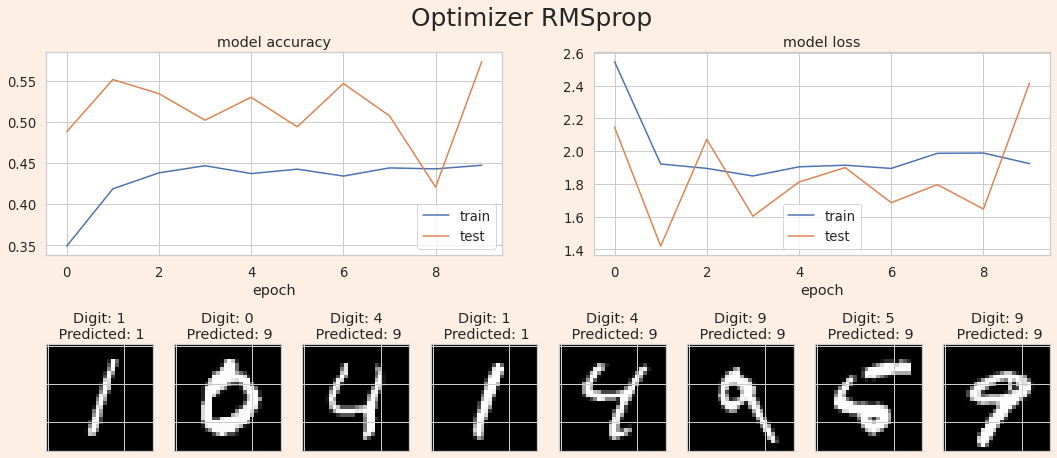

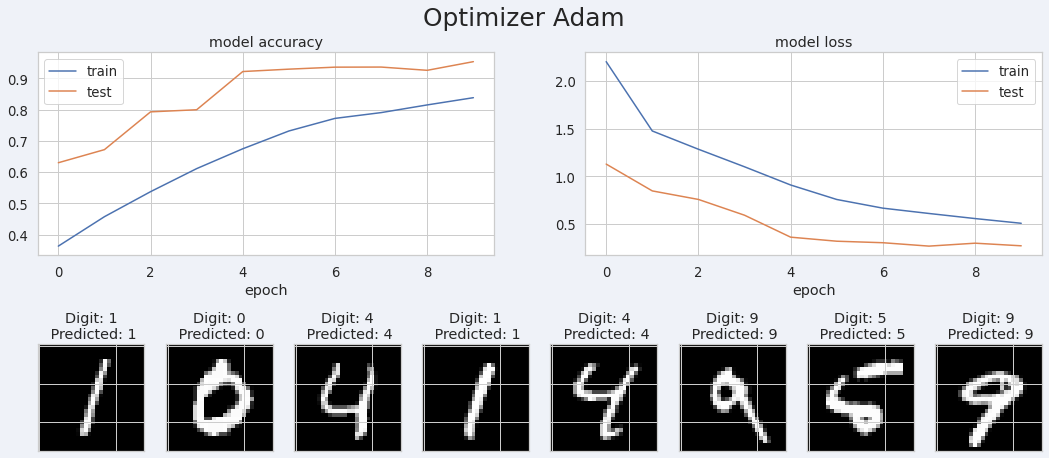

In [6]:
m=0
optimazer =['Adagrad', 'RMSprop','Adam']
for h in optimazer: 
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols).astype('float32')

    Y_train = keras.utils.to_categorical(Y_train, num_classes)
    Y_test = keras.utils.to_categorical(Y_test, num_classes)

    # training parameters
    batch_size = 32
    epochs = 10

    # create the deep neural net
    model_DNN = compile_model(h)

    # train DNN and store training info in history
    history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=0,
              validation_data=(X_test, Y_test))

    # evaluate model
    score = model_DNN.evaluate(X_test, Y_test, verbose=0)

    #X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
    predictions = model_DNN.predict(X_test)

    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)
    
    # gridspec inside gridspec
    fig = plt.figure(figsize=(18,8))
    fig.patch.set_facecolor(color=plt.cm.Pastel2(m))
    fig.patch.set_alpha(0.3)
    m=m+1

    gs0 = gridspec.GridSpec(2, 1, figure=fig)

    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

    ax1 = fig.add_subplot(gs00[0, 0:1])
    ax2 = fig.add_subplot(gs00[0, 1:2])


    # the following syntax does the same as the GridSpecFromSubplotSpec call above:
    gs01 = gs0[1].subgridspec(1, 8)

    ax4 = fig.add_subplot(gs01[0, :1])
    ax5 = fig.add_subplot(gs01[0, 1:2])
    ax6 = fig.add_subplot(gs01[0, 2:3])
    ax7 = fig.add_subplot(gs01[0, 3:4])
    ax8 = fig.add_subplot(gs01[0, 4:5])
    ax9 = fig.add_subplot(gs01[0, 5:6])
    ax10 = fig.add_subplot(gs01[0, 6:7])
    ax11 = fig.add_subplot(gs01[0, 7:8])

    plt.suptitle("Optimizer "+str(h),fontsize='xx-large')
    plt.subplots_adjust(top=0.9)

    for i, ax in enumerate(fig.axes):
        if i ==0:
            ax.plot(history.history['acc'])
            ax.plot(history.history['val_acc'])
            ax.set_title('model accuracy')
            ax.set_xlabel('epoch')
            ax.legend(['train', 'test'], loc='best')
        elif i ==1:
            ax.plot(history.history['loss'])
            ax.plot(history.history['val_loss'])
            ax.set_title('model loss')
            ax.set_xlabel('epoch')
            ax.legend(['train', 'test'], loc='best')
        else:
            ax.imshow(X_test[i, :, :, 0], cmap='gray')    
            ax.set_title("Digit: {}\n Predicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))  
            ax.tick_params(labelbottom=False, labelleft=False)


> Si evince chiaramente che la migliore funzione di ottimizzazione è la funzione **Adam** dal momento che raggiunge un'accuratezza migliore. 

In [36]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols).astype('float32')

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

# training parameters
batch_size = 32
epochs = 10

# create the deep neural net
model_DNN = compile_model('Adam')

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=0)

#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

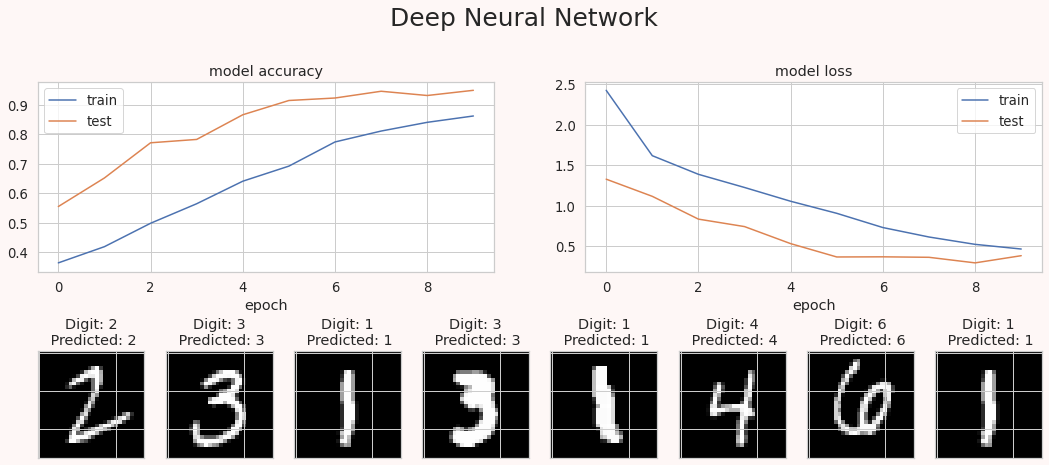

In [37]:
# gridspec inside gridspec
fig = plt.figure(figsize=(18,8))
fig.patch.set_facecolor(color=plt.cm.Pastel1(0))
fig.patch.set_alpha(0.1)

gs0 = gridspec.GridSpec(2, 1, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0, 0:1])
ax2 = fig.add_subplot(gs00[0, 1:2])


# the following syntax does the same as the GridSpecFromSubplotSpec call above:
gs01 = gs0[1].subgridspec(1, 8)

ax4 = fig.add_subplot(gs01[0, :1])
ax5 = fig.add_subplot(gs01[0, 1:2])
ax6 = fig.add_subplot(gs01[0, 2:3])
ax7 = fig.add_subplot(gs01[0, 3:4])
ax8 = fig.add_subplot(gs01[0, 4:5])
ax9 = fig.add_subplot(gs01[0, 5:6])
ax10 = fig.add_subplot(gs01[0, 6:7])
ax11 = fig.add_subplot(gs01[0, 7:8])

plt.suptitle("Deep Neural Network",fontsize='xx-large')
plt.subplots_adjust(top=0.85)

for i, ax in enumerate(fig.axes):
    if i ==0:
        ax.plot(history.history['acc'])
        ax.plot(history.history['val_acc'])
        ax.set_title('model accuracy')
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='best')
    elif i ==1:
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title('model loss')
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='best')
    else:
        r = np.random.randint(0,100)
        ax.imshow(X_test[i+r, :, :, 0], cmap='gray')    
        ax.set_title("Digit: {}\n Predicted: {}".format(np.argmax(Y_test[i+r]), np.argmax(predictions[i+r])))  
        ax.tick_params(labelbottom=False, labelleft=False)

## 2. Algoritmo convolutivo 

In questo caso al posto di considerare un'algortimo sequanziale consideriamo un'algoritmo convolutivo. In particolare, questo tipo di rete mima l'organizzazione della corteccia visiva animale, i cui neuroni individuali sono disposti in maniera tale da rispondere alle regioni di sovrapposizione che tassellano il campo visivo. 

In [9]:
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [10]:
def create_CNN():
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu',))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu',))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(10, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='SGD',
                  metrics=['acc'])
    return model

In [11]:
# training parameters
batch_size = 32
epochs = 5

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1875/1875 [==============================] - 25s 13ms/step - loss: 1.2928 - acc: 0.6468 - val_loss: 0.2286 - val_acc: 0.9314
Epoch 2/5
1875/1875 [==============================] - 23s 13ms/step - loss: 0.2324 - acc: 0.9282 - val_loss: 0.1534 - val_acc: 0.9522
Epoch 3/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1555 - acc: 0.9517 - val_loss: 0.1173 - val_acc: 0.9642
Epoch 4/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1242 - acc: 0.9616 - val_loss: 0.0964 - val_acc: 0.9717
Epoch 5/5
313/313 [==============================] - 1s 5ms/step - loss: 0.0910 - acc: 0.9705

Test loss: 0.09104170650243759
Test accuracy: 0.9704999923706055


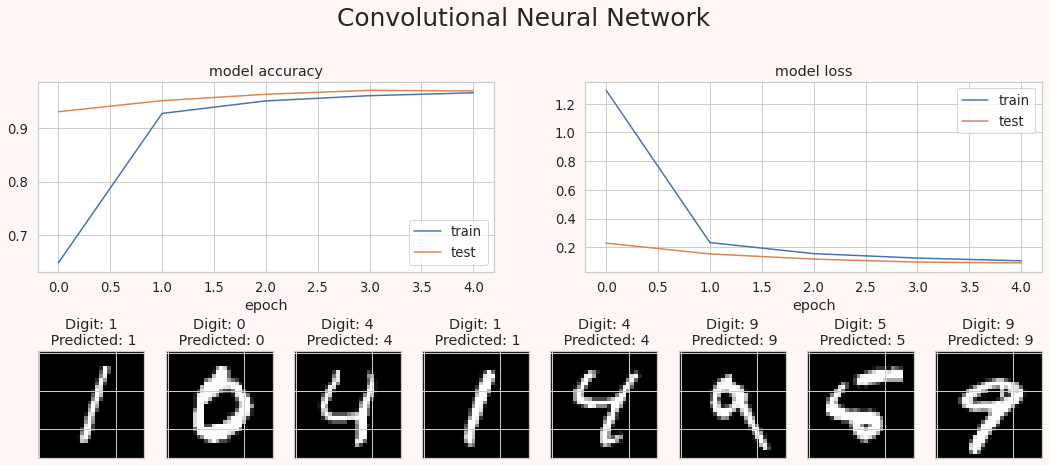

In [12]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_CNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

# gridspec inside gridspec
fig = plt.figure(figsize=(18,8))
fig.patch.set_facecolor(color=plt.cm.Pastel1(0))
fig.patch.set_alpha(0.1)

gs0 = gridspec.GridSpec(2, 1, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0, 0:1])
ax2 = fig.add_subplot(gs00[0, 1:2])


# the following syntax does the same as the GridSpecFromSubplotSpec call above:
gs01 = gs0[1].subgridspec(1, 8)

ax4 = fig.add_subplot(gs01[0, :1])
ax5 = fig.add_subplot(gs01[0, 1:2])
ax6 = fig.add_subplot(gs01[0, 2:3])
ax7 = fig.add_subplot(gs01[0, 3:4])
ax8 = fig.add_subplot(gs01[0, 4:5])
ax9 = fig.add_subplot(gs01[0, 5:6])
ax10 = fig.add_subplot(gs01[0, 6:7])
ax11 = fig.add_subplot(gs01[0, 7:8])

plt.suptitle("Convolutional Neural Network",fontsize='xx-large')
plt.subplots_adjust(top=0.85)

for i, ax in enumerate(fig.axes):
    if i ==0:
        ax.plot(history.history['acc'])
        ax.plot(history.history['val_acc'])
        ax.set_title('model accuracy')
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='best')
    elif i ==1:
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title('model loss')
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='best')
    else:
        ax.imshow(X_test[i, :, :, 0], cmap='gray')    
        ax.set_title("Digit: {}\n Predicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))  
        ax.tick_params(labelbottom=False, labelleft=False)


> Vediamo che il risultato ottenuto è migliore rispetto a quello ottenuto con un algoritmo DNN sia in termini di loss che di accuratezza.

## La mie cifre

Ora utilizziamo i due diversi tipi di reti neuronali per analizzare delle cifre a mano scritte da me. Chiaramente l'algoritmo non è stato allenato con le mie cifre e per tanto ci aspettiamo una riduzione delle prestazioni.

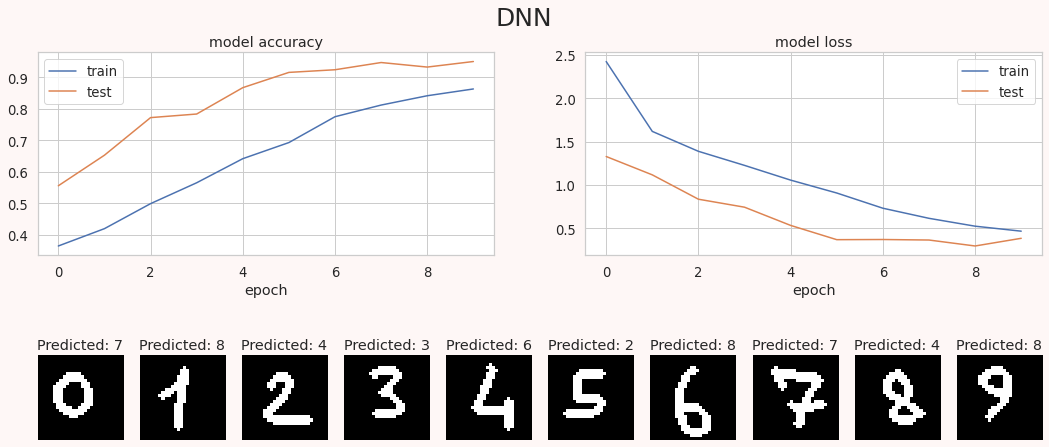

In [52]:
# gridspec inside gridspec
fig = plt.figure(figsize=(18,8))
fig.patch.set_facecolor(color=plt.cm.Pastel1(0))
fig.patch.set_alpha(0.1)

gs0 = gridspec.GridSpec(2, 1, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0, 0:1])
ax2 = fig.add_subplot(gs00[0, 1:2])


# the following syntax does the same as the GridSpecFromSubplotSpec call above:
gs01 = gs0[1].subgridspec(1, 10)

ax4 = fig.add_subplot(gs01[0, :1])
ax5 = fig.add_subplot(gs01[0, 1:2])
ax6 = fig.add_subplot(gs01[0, 2:3])
ax7 = fig.add_subplot(gs01[0, 3:4])
ax8 = fig.add_subplot(gs01[0, 4:5])
ax9 = fig.add_subplot(gs01[0, 5:6])
ax10 = fig.add_subplot(gs01[0, 6:7])
ax11 = fig.add_subplot(gs01[0, 7:8])
ax12 = fig.add_subplot(gs01[0, 8:9])
ax13 = fig.add_subplot(gs01[0, 9:10])

plt.suptitle("DNN",fontsize='xx-large')
plt.subplots_adjust(top=0.9)

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='best')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='best')

ax = fig.axes

full_data = np.zeros((10,28,28))
for k in range(0,10):
    digit_filename = str(k)+".png"
    digit_in = Image.open(digit_filename).convert('L')
    pix=digit_in.load();
    data = np.zeros((28, 28))
    for j in range(28):
        for i in range(28):
            data[i,j]=pix[j,i]
    
    data = data.reshape(1, 28*28).astype('float32')

    #X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
    predictions = model_DNN.predict(data)
    
    data = data.reshape(28, 28)
    
    ax[k+2].imshow(data, cmap='gray')    
    ax[k+2].set_title("Predicted: "+ str(np.argmax(predictions)))
    ax[k+2].tick_params(labelbottom=False, labelleft=False)
    ax[k+2].axis('off')
    
plt.show()

>I risultati che otteniamo attraverso un algortimo DNN sono pessimi. Solo in due casi su dieci otteniamo dieci numeri otteniamo il risultato corretto. Valutiamo ora come si comporta l'algortimo CNN.

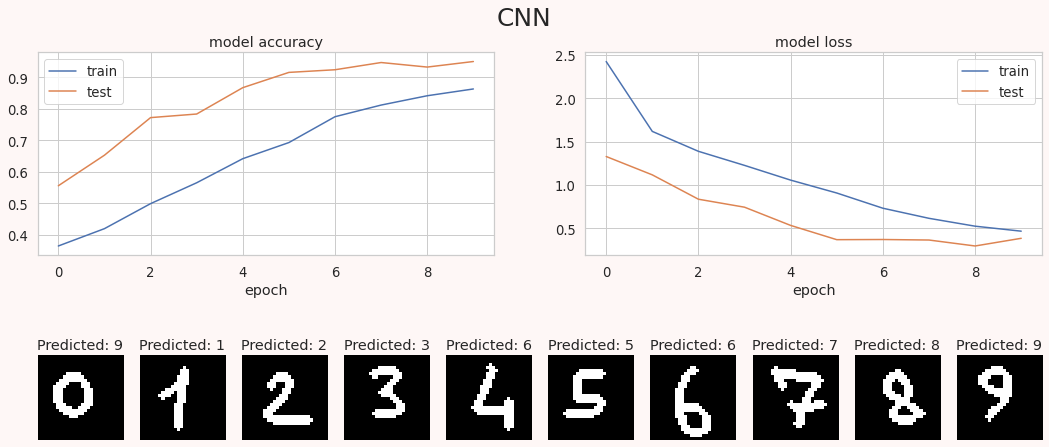

In [44]:
# gridspec inside gridspec
fig = plt.figure(figsize=(18,8))
fig.patch.set_facecolor(color=plt.cm.Pastel1(0))
fig.patch.set_alpha(0.1)

gs0 = gridspec.GridSpec(2, 1, figure=fig)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0, 0:1])
ax2 = fig.add_subplot(gs00[0, 1:2])


# the following syntax does the same as the GridSpecFromSubplotSpec call above:
gs01 = gs0[1].subgridspec(1, 10)

ax4 = fig.add_subplot(gs01[0, :1])
ax5 = fig.add_subplot(gs01[0, 1:2])
ax6 = fig.add_subplot(gs01[0, 2:3])
ax7 = fig.add_subplot(gs01[0, 3:4])
ax8 = fig.add_subplot(gs01[0, 4:5])
ax9 = fig.add_subplot(gs01[0, 5:6])
ax10 = fig.add_subplot(gs01[0, 6:7])
ax11 = fig.add_subplot(gs01[0, 7:8])
ax12 = fig.add_subplot(gs01[0, 8:9])
ax13 = fig.add_subplot(gs01[0, 9:10])

plt.suptitle("CNN",fontsize='xx-large')
plt.subplots_adjust(top=0.9)

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='best')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='best')

ax = fig.axes
    
for k in range(0,10):
    digit_filename = str(k)+".png"
    digit_in = Image.open(digit_filename).convert('L')
    pix=digit_in.load();
    data = np.zeros((28, 28))
    for j in range(28):
        for i in range(28):
            data[i,j]=pix[j,i]
                
    if keras.backend.image_data_format() == "channels_first":
        data = data.reshape(1, 1, 28, 28)
    else:
        data = data.reshape(1, 28, 28, 1)

    #X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
    predictions = model_CNN.predict(data)
        
    data = data.reshape(28, 28)

    ax[k+2].imshow(data, cmap='gray')    
    ax[k+2].set_title("Predicted: "+ str(np.argmax(predictions)))
    ax[k+2].tick_params(labelbottom=False, labelleft=False)
    ax[k+2].axis('off')

plt.show()

>I risultati, sebbene non siano ancora soddisfacenti (8/10 giusti), sono notevolemente migliori rispetto all'algortimo DNN. Questo ci dice che l'algoritmo CNN è molto più flessibile e versatile rispetto al DNN.